In [2]:
%matplotlib inline
from pylab import *
from scipy.special import expit

class sigmoid():
    @staticmethod
    def f(x):
        return expit(x)
    
    @staticmethod
    def df(x):
        return sigmoid.f(x) * (1 - sigmoid.f(x))

class sqrcost():
    
    @staticmethod
    def f(y, a):
        """
            y -> expected
            a -> actual
        """
        assert a.shape == y.shape
        # averaging over all test cases
        return 0.5 * np.sum(np.average(np.square(y - a), axis = 0))
    
    @staticmethod
    def df(y, a):
        assert a.shape == y.shape
        return (a - y) / a.shape[0] # number or test cases to average them out
    
class NN():
    """
        struct => (2, 1)
        number of units in each layer
    """
    def __init__(self, struct, cost, sigma):
        self.N = len(struct)
        self.struct = struct
        
        self.b = [np.ones(shape=(1,x), dtype=np.float64) for x in struct[1:]]
        self.w = [np.random.randn(n, m) / np.sqrt(n) for n,m in zip(struct, struct[1:])]

        self.cost = cost
        self.sigma = sigma
        
    def ff(self, x):
        self.a = [x]
        self.z = []
        for w, b in zip(self.w, self.b):
            x = np.dot(x, w) + b
            self.z.append(x)
            x = self.sigma.f(x)
            self.a.append(x)
        return x
    
    def grad(self, x, y):
        self.ff(x)
        self.d = [0 for _ in range(self.N - 1)]
        self.d[-1] = self.cost.df(y, self.a[-1]) * self.sigma.df(self.z[-1])
        for l in range(2, self.N):
            self.d[-l] = np.dot(self.d[-l + 1], self.w[-l + 1].T) * self.sigma.df(self.z[-l])
            
        wgrad = []
        bgrad = []
        for i in range(self.N - 1):
            # summing all errors
            # They are already averaged in cost function
            bgrad.append(np.sum(self.d[i], axis = 0)) 
            wgrad.append(np.dot(self.a[i].T,self.d[i]))
        
        return (wgrad, bgrad)
    
    def train(self, x, y, minibatch = 10, learn = 0.001):
        assert x.shape[1] == self.struct[0]
        assert y.shape[1] == self.struct[-1]
        assert x.shape[0] == y.shape[0]
        
        sz = self.struct[0]
        joinedData = np.hstack((x, y))
        self.trainJoinedData(joinedData, sz, minibatch=minibatch, learn=learn)
        
    def trainJoinedData(self, data, separatingColumn, minibatch, learn):
        np.random.shuffle(data)
        sz = separatingColumn
        for batch in np.split(data, minibatch):
            (gw, gb) = self.grad(batch[:, :sz], batch[:, sz:])
            for w, dw in zip(self.w, gw):
                w -= learn * dw
    
            for b, db in zip(self.b, gb):
                b -= learn * db
            
        
    def avgCost(self, x, y):
        return self.cost.f(y, self.ff(x))
    
    def ngrad(self, x, y):
        eps = 1e-4
        wgrad = list(map(np.zeros_like, self.w))
        bgrad = list(map(np.zeros_like, self.b))
        
        for i in range(len(self.w)):
            rr, cc = self.w[i].shape
            for r in range(rr):
                for c in range(cc):
                    o = self.w[i][r,c]
                    self.w[i][r,c] = o + eps
                    uc = self.avgCost(x, y)
                    self.w[i][r,c] = o - eps
                    lc = self.avgCost(x, y)
                    self.w[i][r,c] = o

                    wgrad[i][r,c] = (uc - lc) / (2*eps)
    
        for i in range(len(self.b)):
            rr, cc = self.b[i].shape
            for r in range(rr):
                for c in range(cc):
                    o = self.b[i][r,c]
                    self.b[i][r,c] = o + eps
                    uc = self.avgCost(x, y)
                    
                    self.b[i][r,c] = o - eps
                    lc = self.avgCost(x, y)    
                    self.b[i][r,c] = o

                    bgrad[i][r,c] = (uc - lc) / (2*eps)
        
        return (wgrad, bgrad)
    
nn = NN((1,3,3), sqrcost, sigmoid)

x_train = np.array([[1], [0]])
y_train = np.array([[0,0,0], [1,0, 0]])

np.set_printoptions(precision = 10)    

In [3]:
from IPython.display import clear_output

print (nn.ff(x_train[[0], :]))
print ("=== z & a ===")
print (nn.z)
print (nn.a)

print ("=== numerical gradient ===")
nw, nb = nn.ngrad(x_train[[0], :], y_train[[0], :])
print (nw[0].shape, nw)
print(nb[0].shape, nb)

print ("=== backprop gradient ===")
w, b = nn.grad(x_train[[0], :], y_train[[0], :])
print (w[0].shape, w)
print(b[0].shape, b)

print ("=== d ===")
print (nn.d)

print ("=== diffs ===")
diffw = np.max([np.max(np.abs(a-b)) for a,b in zip(nw, w)])
diffb = np.max([np.max(np.abs(a-b)) for a,b in zip(nb, b)])

if diffw < 1e-7 and diffb < 1e-7:
    clear_output(True)
    
print ("max w diff: ", diffw)
print ("max b diff: ", diffb)

max w diff:  8.09605854579e-11
max b diff:  1.39752098782e-10


In [4]:
print (nn.ff(x_train[0, :]))
print ("=== z & a[0] ===")
print (nn.z)
print (nn.a)

z0 = nn.z
a0 = nn.a

print (nn.ff(x_train[1, :]))
print ("=== z & a[1] ===")
print (nn.z)
print (nn.a)

z1 = nn.z
a1 = nn.a

print (nn.ff(x_train))
print ("=== z & a ===")
zzz = [np.vstack([a, b]) for a,b in zip(z0, z1)]
aaa = [np.vstack([a, b]) for a,b in zip(a0, a1)]
print(zzz)
print (nn.z)
print (nn.a)

for a,b in zip(nn.z, zzz):
    print (a.shape, b.shape)
    
for a,b in zip(nn.a, aaa):
    print (a.shape, b.shape)

zcond = np.all([np.allclose(a,b) for a,b in zip(zzz, nn.z)])
acond = np.all([np.allclose(a,b) for a,b in zip(aaa, nn.a)])

if zcond and acond:
    clear_output(True)
    print ("Correctly calculation a/z in batch vs singular case")


Correctly calculation a/z in batch vs singular case


In [5]:
nn.grad(x_train[[0], :], y_train[[0], :])
print ("=== d[0] ===")
print (nn.d)
d0 = nn.d

nn.grad(x_train[[1], :], y_train[[1], :])
print ("=== d[1] ===")
print (nn.d)
d1 = nn.d

nn.grad(x_train, y_train)
print ("=== z & a ===")
print (nn.d)
ddd = [np.vstack([a, b]) for a,b in zip(d0, d1)]

dcond = np.all([np.allclose(a,b) for a,b in zip(ddd, nn.d)])

if dcond:
    clear_output(True)
    print ("Correctly calculation d in batch vs singular case")

=== d[0] ===
[array([[ 0.0306512174,  0.0101924834, -0.0071650546]]), array([[ 0.1451846294,  0.1244852034,  0.1445289832]])]
=== d[1] ===
[array([[ 0.0101865708,  0.0113092666, -0.0010324324]]), array([[-0.0504744143,  0.1273632153,  0.136742898 ]])]
=== z & a ===
[array([[ 0.0153256087,  0.0050962417, -0.0035825273],
       [ 0.0050932854,  0.0056546333, -0.0005162162]]), array([[ 0.0725923147,  0.0622426017,  0.0722644916],
       [-0.0252372072,  0.0636816077,  0.068371449 ]])]


In [6]:
from IPython.display import clear_output

l = 1

w, b = nn.grad(x_train[[0], :], y_train[[0], :])
w1, b1 = nn.ngrad(x_train[[0], :], y_train[[0], :])

print ("=== d[0] ===")
print ("w\n", w[l])
print ("b\n", b[l])

print("=== num ===")
print (w1[l])
print (b1[l])

w, b =nn.grad(x_train[[1], :], y_train[[1], :])
w1, b1 =nn.ngrad(x_train[[1], :], y_train[[1], :])

print ("=== d[1] ===")
print ("w\n", w[l])
print ("b\n", b[l])

print("=== num ===")
print (w1[l])
print (b1[l])

w, b = nn.grad(x_train, y_train)
w1, b1 =nn.ngrad(x_train, y_train)

print ("=== full ===")
print ("dw\n", w[l])
print ("db\n", b[l])

print ("ww\n", nn.w[l])

print("=== num ===")
print ("dw\n", w1[l])
print ("")
print ("db\n", b1[l])

wclose = np.allclose(w[l], w1[l])
bclose = np.allclose(b[l], b1[l])

print ("dw [all close]:", wclose)
print ("db [all close]:", bclose)

if wclose and bclose:
    clear_output(True)
    print("everything is fine :)")

everything is fine :)


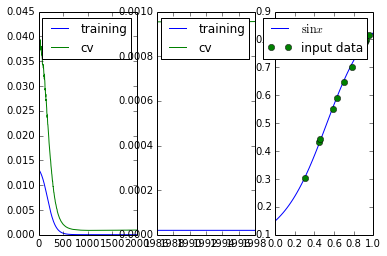

In [51]:
from tqdm import trange
from IPython.display import clear_output

x_train = np.random.uniform(size=(10, 1))
y_train = np.sin(x_train)
xy_train = np.hstack((x_train, y_train))

x_cv = np.linspace(0,1,200).reshape(200, 1)
y_cv = np.sin(x_cv)
x_test, y_test = None, None

maxEpoh = 2000
epoh = []
t_err = []
cv_err = []
nn = NN((1,3,1), sqrcost, sigmoid)

print (x_train.shape)

for i in trange(maxEpoh + 1):
    nn.trainJoinedData(xy_train, 1, minibatch = 10, learn=0.3)
    if i % 3 == 0:
        epoh.append(i)
        t_err.append(nn.avgCost(x_train, y_train))
        cv_err.append(nn.avgCost(x_cv, y_cv))
    
    if i % 20 == 0:
        clear_output(True)
        f, (ax1, ax2, ax3) = plt.subplots(1, 3)
        
        ax1.plot(epoh, t_err, label="training")
        ax1.plot(epoh, cv_err, label="cv")
        ax1.plot()
        ax1.legend()
        
        ax2.plot(epoh[-5:], t_err[-5:], label="training")
        ax2.plot(epoh[-5:], cv_err[-5:], label="cv")
        ax2.plot()
        ax2.legend()
        
        
        x = np.linspace(0,1, 50).reshape(50,1)
        y = nn.ff(x)
        ax3.plot(x, y, label="$\sin x$")
        ax3.plot(x_train, y_train, 'o', label='input data')
        ax3.legend()
  
        plt.show()